In [1]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
import tensorflow as tf
from datetime import datetime

C:\Users\vivs_\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vivs_\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
dataset = read_csv("60min_Seg.csv",
                   parse_dates={'ST' : ['StartTime15']},
                   infer_datetime_format=True, 
                   index_col= 1,
                   na_values=['nan','?'])
dataset.fillna(0, inplace=True)
values = dataset.values


In [3]:
dataset.head(4)

,ST,StartTime,StartTimeConv,EndTime,Speed,Wind Direction,Wind Speed,Precipitation amount,Quality,AirTemp,Snow_Depth,Ground_Cond
SegmentId,,,,,,,,,,,,
226255131,43619.333333333,6/3/2019 8:00,43619.33333,6/3/2019 9:00,97.090909,138,5.1,0.0,G,14.1,0.0,0
226255131,43619.375,6/3/2019 9:00,43619.37500,6/3/2019 10:00,93.466667,180,8.4,0.0,G,17.4,0.0,0
226255131,43619.416666666,6/3/2019 10:00,43619.41667,6/3/2019 11:00,99.033898,179,8.2,0.1,G,17.5,0.0,0
226255131,43619.458333333,6/3/2019 11:00,43619.45833,6/3/2019 12:00,94.666667,185,8.0,0.0,G,17.5,0.0,0


In [5]:
dataset.drop(columns  = [ 'Quality','EndTime','StartTime','StartTimeConv','Ground_Cond','Snow_Depth','Precipitation amount'], inplace = True)
values = dataset.values
# ensure all data is float
values = values.astype('float32')

KeyError: "['Quality' 'EndTime' 'StartTime' 'StartTimeConv' 'Ground_Cond'\n 'Snow_Depth' 'Precipitation amount'] not found in axis"

In [6]:
dataset.head(4)

,ST,Speed,Wind Direction,Wind Speed,AirTemp
SegmentId,,,,,
226255131,43619.333333333,97.090909,138,5.1,14.1
226255131,43619.375,93.466667,180,8.4,17.4
226255131,43619.416666666,99.033898,179,8.2,17.5
226255131,43619.458333333,94.666667,185,8.0,17.5


In [7]:
dataset.head(4)

,ST,Speed,Wind Direction,Wind Speed,AirTemp
SegmentId,,,,,
226255131,43619.333333333,97.090909,138,5.1,14.1
226255131,43619.375,93.466667,180,8.4,17.4
226255131,43619.416666666,99.033898,179,8.2,17.5
226255131,43619.458333333,94.666667,185,8.0,17.5


In [8]:
# normalizing input features
scaler = MinMaxScaler(feature_range=(0, 4))
scaled = scaler.fit_transform(values)
scaled =pd.DataFrame(scaled)
scaled.head(4)

,0,1,2,3,4
0,0.000000,2.824810,1.533333,1.030303,2.533333
1,0.000183,2.711360,2.000000,1.696970,2.900000
2,0.000381,2.885631,1.988889,1.656566,2.911111
3,0.000549,2.748924,2.055556,1.616162,2.911111


In [10]:
def create_ts_data(dataset, lookback=1, predicted_col=2):
    temp=dataset.copy()
    temp["id"]= range(1, len(temp)+1)
    temp = temp.iloc[:-lookback, :]
    temp.set_index('id', inplace =True)
    predicted_value=dataset.copy()
    predicted_value = predicted_value.iloc[lookback:,predicted_col]
    predicted_value.columns=["Predcited"]
    predicted_value= pd.DataFrame(predicted_value)
    
    predicted_value["id"]= range(1, len(predicted_value)+1)
    predicted_value.set_index('id', inplace =True)
    final_df= pd.concat([temp, predicted_value], axis=1)
    #final_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)','var1(t)']
    #final_df.set_index('Date', inplace=True)
    return final_df

In [12]:
#We now create the time series dataset with looking back one time step

reframed_df= create_ts_data(scaled, 1,4)
reframed_df.fillna(0, inplace=True)

reframed_df.columns = ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)','var5(t-1)', 'var1(t)']
print(reframed_df.head(4))

    var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)
id                                                                 
1    0.000000   2.824810   1.533333   1.030303   2.533333  2.900000
2    0.000183   2.711360   2.000000   1.696970   2.900000  2.911111
3    0.000381   2.885631   1.988889   1.656566   2.911111  2.911111
4    0.000549   2.748924   2.055556   1.616162   2.911111  2.788889


In [13]:
# split into train and test sets
values = reframed_df.values
training_sample =int( len(dataset) *0.75)
train = values[:training_sample, :]
test = values[training_sample:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [14]:
# reshape input to be 3D [samples, time steps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(16066, 1, 5) (16066,) (5355, 1, 5) (5355,)


In [15]:
model_lstm = Sequential()
model_lstm.add(LSTM(384, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
model_lstm.add(LSTM(units=70, return_sequences=True))
model_lstm.add(LSTM(units=70))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mae', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 384)            599040    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 70)             127400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                39480     
_________________________________________________________________
dense (Dense)                (None, 1)                 71        
Total params: 765,991
Trainable params: 765,991
Non-trainable params: 0
_________________________________________________________________


In [16]:
# fit network
lstm_history = model_lstm.fit(train_X, train_y, epochs=100,validation_data=(test_X, test_y), batch_size=64, shuffle=False)

Epoch 1/100
252/252 [==============================] - 19s 15ms/step - loss: 0.9016 - val_loss: 0.7232
Epoch 2/100
252/252 [==============================] - 2s 9ms/step - loss: 0.3964 - val_loss: 0.9008
Epoch 3/100
252/252 [==============================] - 2s 8ms/step - loss: 0.4995 - val_loss: 1.0290
Epoch 4/100
252/252 [==============================] - 2s 9ms/step - loss: 0.6780 - val_loss: 1.0391
Epoch 5/100
252/252 [==============================] - 2s 9ms/step - loss: 0.7475 - val_loss: 1.0188
Epoch 6/100
252/252 [==============================] - 2s 9ms/step - loss: 0.7323 - val_loss: 0.9813
Epoch 7/100
252/252 [==============================] - 2s 10ms/step - loss: 0.7115 - val_loss: 0.9317
Epoch 8/100
252/252 [==============================] - 2s 9ms/step - loss: 0.6801 - val_loss: 0.8918
Epoch 9/100
252/252 [==============================] - 2s 9ms/step - loss: 0.6397 - val_loss: 0.8835
Epoch 10/100
252/252 [==============================] - 2s 9ms/step - loss: 0.5802 - val

252/252 [==============================] - 2s 8ms/step - loss: 0.0452 - val_loss: 0.0902
Epoch 82/100
252/252 [==============================] - 2s 9ms/step - loss: 0.0448 - val_loss: 0.0720
Epoch 83/100
252/252 [==============================] - 2s 9ms/step - loss: 0.0452 - val_loss: 0.0656
Epoch 84/100
252/252 [==============================] - 2s 9ms/step - loss: 0.0436 - val_loss: 0.0759
Epoch 85/100
252/252 [==============================] - 2s 9ms/step - loss: 0.0438 - val_loss: 0.0732
Epoch 86/100
252/252 [==============================] - 2s 8ms/step - loss: 0.0457 - val_loss: 0.0734
Epoch 87/100
252/252 [==============================] - 2s 8ms/step - loss: 0.0455 - val_loss: 0.0863
Epoch 88/100
252/252 [==============================] - 2s 8ms/step - loss: 0.0456 - val_loss: 0.0835
Epoch 89/100
252/252 [==============================] - 2s 8ms/step - loss: 0.0451 - val_loss: 0.0749
Epoch 90/100
252/252 [==============================] - 2s 8ms/step - loss: 0.0454 - val_loss: 

In [17]:
pred_y =  model_lstm.predict(test_X)

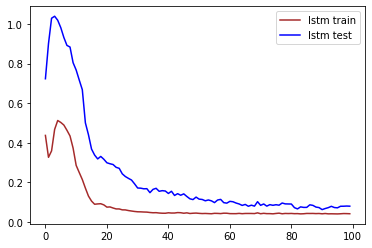

In [18]:
pyplot.plot(lstm_history.history['loss'], label='lstm train', color='brown')
pyplot.plot(lstm_history.history['val_loss'], label='lstm test', color='blue')
pyplot.legend()
pyplot.show()

In [20]:
test_y.reshape(5355,1)

array([[1.2444444 ],
       [1.1999999 ],
       [1.2111111 ],
       ...,
       [0.7888889 ],
       [0.76666665],
       [0.82222223]], dtype=float32)

In [21]:
pred_y

array([[1.2544132 ],
       [1.2557514 ],
       [1.2102894 ],
       ...,
       [0.7227092 ],
       [0.73161626],
       [0.7062751 ]], dtype=float32)

0.010633414
0.9714388888231943
0.10311844490632016
0.079401076


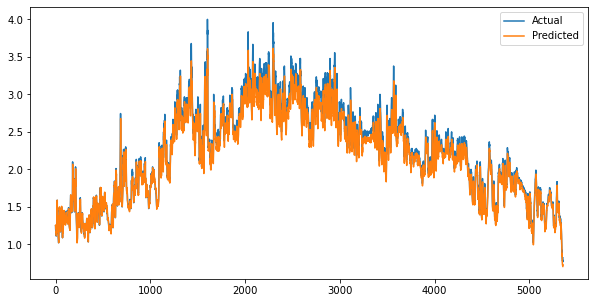

In [22]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,5)

from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(test_y, pred_y)
R2 = r2_score(test_y, pred_y)
RMSE = sqrt(mean_squared_error(test_y, pred_y))
MAE = mean_absolute_error(test_y, pred_y)


print(MSE)
print(R2)
print(RMSE)
print(MAE)

#plotting predicted test value vs actual test value
plt.plot(test_y, label = 'Actual')
plt.plot(pred_y, label = 'Predicted')
plt.legend()
plt.show()

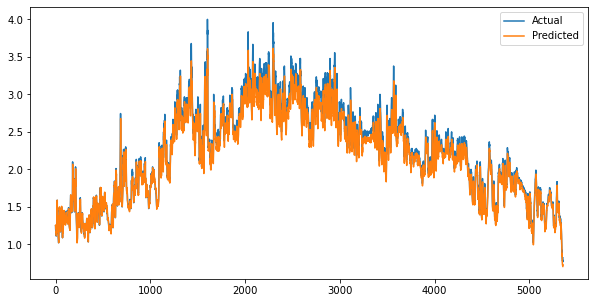

In [28]:
#visualization over full data
tra = test_X
tes = test_y
fp = model_lstm.predict(tra)
plt.plot(tes, label = 'Actual')
plt.plot(fp, label = 'Predicted')
plt.legend()
plt.show()

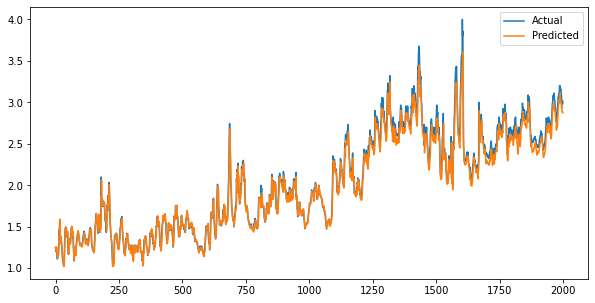

In [29]:
#over small part of data
plt.plot(tes[:2000], label = 'Actual')
plt.plot(fp[:2000], label = 'Predicted')
plt.legend()
plt.show()